In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from time import time
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import euclidean_distances

# Get data
train_data_small = pd.read_csv(r"MNIST_train_small.csv")
test_data_small = pd.read_csv(r"MNIST_test_small.csv")

In [4]:
# Func to extract features and labels form dataset
def get_features_targets(data):

    targets= data.iloc[:, 0].to_numpy()
    features= data.iloc[:, 1:].to_numpy()

    return features, targets

In [ ]:
# def indice_flattener(x, data_column_no):
#     new_indice = []
#     for i,j in enumerate(x):

#         if i == 0:
#             new_indice.append(int(j))
#         else:
#             new_indice.append(int(j+(i*data_column_no)))
    
#     return new_indice

# # Sorting routine for Distances
# def sort_dist(x, max_k):
#     ind_data = np.zeros((x.shape[0], max_k)).astype(int)

#     for i in range(0, max_k):
#         current_ind = np.argmin(x, axis=1)
#         ind_data[:, i] = current_ind
#         flattened_distances = x.flatten()
#         flattened_distances[indice_flattener(current_ind, x.shape[1])] = x.max()+1
#         x = flattened_distances.reshape(x.shape)
    
#     return ind_data

In [5]:
# Create KNN Classifier

class KNN:

    # Initialize Object
    def __init__(self, k, distance=None):
        if distance == None:
            self.norm = 2
        else:
            self.norm = distance
        self.features = None
        self.labels = None
        self.k = k

    # Fit to training set
    def fit(self, features, labels):
        self.features = features
        self.labels = labels

    
    # Prediction for dataset
    def predict(self, x, mult=None, all=None):

        if mult == None and all == None:
            predictions = cdist(x, self.features, metric='minkowski', p=self.norm)
            pred_ind = np.argsort(predictions, axis=1)[:, :self.k]
            preds = pd.DataFrame(self.labels[pred_ind]).mode(axis=1).iloc[:, 0].values

        elif all == 'all':
            preds = cdist(x, self.features, metric='minkowski', p=self.norm)
        
        else:
            predictions = cdist(x, self.features, metric='minkowski', p=self.norm)
            pred_ind = np.argsort(predictions, axis=1)[:, :max(self.k)]
            preds = self.labels[pred_ind]

        return preds
    
    # Prediction for multiple K
    def error_mult(self, x, true_labels, prediction_data = None):

        if isinstance(self.k, (np.ndarray, list)):
            preds = self.predict(x, mult=True)
            pred_df = pd.DataFrame(columns=[str(i) for i in self.k])
            errors_k = []

            for i in self.k:
                pred_labels = pd.DataFrame(preds).iloc[:,:i].mode(axis=1).iloc[:,0].values
                pred_df[str(i)] = pred_labels
                errors_k.append(self.error_score(pred_labels, true_labels))
            
            if prediction_data != None :
                return pred_df, errors_k
            
            if prediction_data == None:
                return errors_k
        
        else:

            print("This method is used for multiple K. Enter a list of K-values.")
            pass

    # Error score
    def error_score(self, predicted, data_label):
        errors = predicted - data_label
        error_score = len(errors[errors!=0])/len(data_label)

        return error_score

    # Leave One Out CV Score
    def loocv_score(self):

        all_pred = self.predict(self.features, all='all')

        if isinstance(self.k, (np.ndarray, list)):
            k_errors = []
            sorted_ind = np.argsort(all_pred, axis=1)

            for i in self.k:
                pred_ind = sorted_ind[:, 1:i+1]
                preds = pd.DataFrame(self.labels[pred_ind]).mode(axis=1).iloc[:, 0].values
                k_errors.append(self.error_score(preds, self.labels))

            return k_errors
        
        else:
            pred_ind = np.argsort(all_pred, axis=1)[:, 1:self.k+1]
            preds = pd.DataFrame(self.labels[pred_ind]).mode(axis=1).iloc[:, 0].values

            return self.error_score(preds, self.labels)
        
    # Leave One Out CV Score - 2
    def loocv_score_big(self):

        data_split = [self.features[(i*10000):((i+1)*10000)] for i in range(0,6)]
        label_split = [self.labels[(i*10000):((i+1)*10000)] for i in range(0,6)]

        k_errors = np.zeros(len(self.k))

        if isinstance(self.k, (np.ndarray, list)):

            for i in tqdm(range(len(data_split))):
                curr_pred = self.predict(data_split[i], all='all')

                k_curr_errors = np.zeros(len(self.k))

                sorted_ind = np.argsort(curr_pred, axis=1)

                for j, l in enumerate(self.k):
                    pred_ind = sorted_ind[:, 1:l+1]
                    preds = pd.DataFrame(self.labels[pred_ind]).mode(axis=1).iloc[:, 0].values
                    k_curr_errors[j] = self.error_score(preds, label_split[i])

                k_errors += k_curr_errors

            return k_errors/len(data_split)
        
        else:
            
            for i in tqdm(range(len(data_split))):
                curr_pred = self.predict(data_split[i], all='all')

                k_curr_errors = np.zeros(len(self.k))

                sorted_ind = np.argsort(curr_pred, axis=1)
                pred_ind = sorted_ind[:, 1:self.k+1]
                preds = pd.DataFrame(self.labels[pred_ind]).mode(axis=1).iloc[:, 0].values
                k_curr_errors = self.error_score(preds, label_split[i])

                k_errors += k_curr_errors

            return k_errors/len(data_split)
        
    # Search for best metric 
    def grid_search_dist(self, dist_range):

        dist_df = pd.DataFrame(columns=[str(i) for i in dist_range])

        for i in tqdm(dist_range): 
            self.norm = i
            dist_df[str(i)] = self.loocv_score()

        return dist_df


In [10]:
# Get features and labels for datasets
train_small_X, train_small_y = get_features_targets(train_data_small)
test_small_X, test_small_y = get_features_targets(test_data_small)

In [11]:
# Create KNN instance
KNN_test = KNN(k=3)
KNN_test.fit(train_small_X, train_small_y)

In [12]:
# Test working on small subset
train_small_now = train_small_X[:100]
predictions_now = KNN_test.predict(train_small_now)
train_y_now = train_small_y[:100]


# Error score test with small data
print(KNN_test.error_score(predictions_now, train_y_now))

0.07


In [13]:
# Calcualte errors on MNIST small dataset

k_list = np.array([i for i in range(1,21)])
KNN_mult = KNN(k=k_list)
KNN_mult.fit(train_small_X, train_small_y)

errors_training = KNN_mult.error_mult(train_small_X, train_small_y)
# print(errors_training)

errors_testing = KNN_mult.error_mult(test_small_X, test_small_y)
# print(errors_testing)

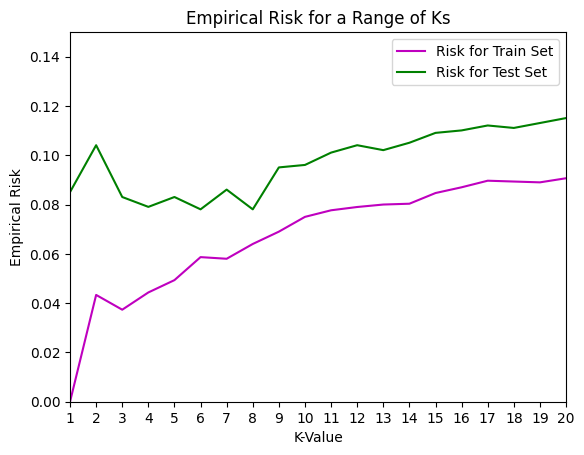

In [14]:
import matplotlib.pyplot as plt

plt.plot(k_list, errors_training, color='m', label='Risk for Train Set')
plt.plot(k_list, errors_testing, color='g', label='Risk for Test Set')
plt.title('Empirical Risk for a Range of Ks')
plt.ylabel('Empirical Risk')
plt.xlabel('K-Value')
plt.ylim((0,0.15))
plt.xlim((1,20))
plt.xticks(k_list)
plt.legend()
plt.show()

In [143]:
risk_table = pd.DataFrame({'Risk for Training Set':errors_training, 'Risk for Testing Set':errors_testing}, index=k_list)
risk_table = risk_table.round(decimals=3)

In [26]:
risk_table.to_csv(r'Plots\Risk_wo_LOOCV.csv')

In [15]:
LOOCV_score = KNN_mult.loocv_score()

In [16]:
LOOCV_score_cust = KNN_mult.loocv_score_custom()

In [32]:
LOOCV_risk_table = pd.DataFrame(LOOCV_score, columns=['Leave-One-Out CV risk score'], index=[i for i in k_list])
LOOCV_risk_table = LOOCV_risk_table.round(decimals=3)

In [33]:
LOOCV_risk_table.to_csv(r'Plots\Risk_w_LOOCV.csv')

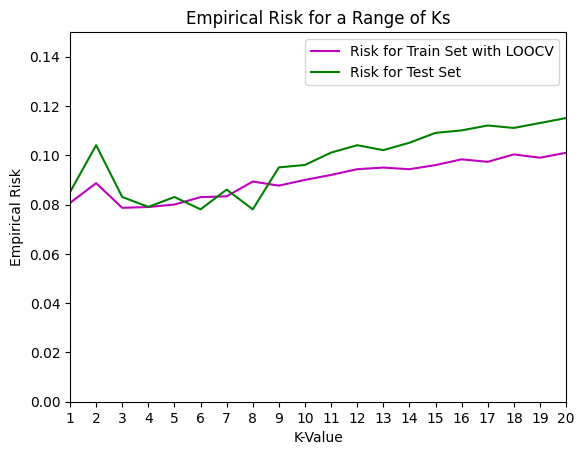

In [29]:
plt.plot(k_list, LOOCV_score, color='m', label='Risk for Train Set with LOOCV')
plt.plot(k_list, errors_testing, color='g', label='Risk for Test Set')
plt.title('Empirical Risk for a Range of Ks')
plt.ylabel('Empirical Risk')
plt.xlabel('K-Value')
plt.ylim((0,0.15))
plt.xlim((1,20))
plt.xticks(list(range(1,21)))
plt.legend()
plt.show()

In [ ]:
dist_range = [i for i in range(1,16)]
dist_df = KNN_mult.grid_search_dist(dist_range=dist_range)

100%|██████████| 15/15 [7:49:32<00:00, 1878.15s/it]  


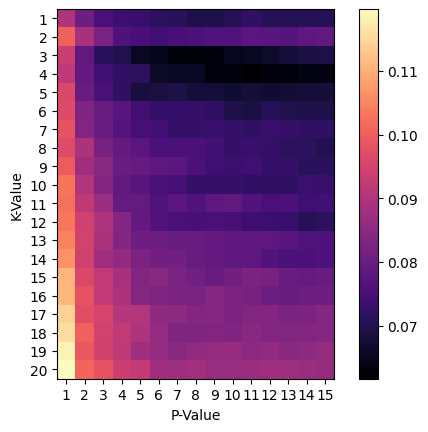

In [135]:
plt.imshow(dist_df, cmap='magma')
plt.xlabel('P-Value')
plt.ylabel('K-Value')
plt.xticks(ticks=range(0,15), labels=dist_range)
plt.yticks(ticks=range(0,20), labels=k_list)
plt.colorbar()
plt.show()

In [ ]:
min_error = dist_df.to_numpy().min()
print(f"{min_error:.4f} error rate acheived at k={np.where(dist_df == min_error)[0][0]+1} and p={np.where(dist_df == min_error)[1][0]+1}")

0.0617 error rate acheived at k=3 and p=10


In [2]:
train_data = pd.read_csv(r"MNIST_train.csv")
test_data = pd.read_csv(r"MNIST_test.csv")

In [6]:
# Get features and labels for datasets
train_X, train_y = get_features_targets(train_data)
test_X, test_y = get_features_targets(test_data)

train_X_binary = (train_X > 128).astype(int)

In [14]:
k_list = np.array([i for i in range(1,21)])

KNN_big_loocv = KNN(k=k_list, distance=2)
KNN_big_loocv.fit(train_X_binary, train_y)

In [15]:
KNN_big_loocv_scores = KNN_big_loocv.loocv_score_big()

100%|██████████| 6/6 [1:22:05<00:00, 820.98s/it]


In [21]:
KNN_big_df = pd.DataFrame({'Empirical Risk with LOOCV': KNN_big_loocv_scores}, index=k_list)
KNN_big_df = KNN_big_df.round(decimals=3)

In [22]:
print(KNN_big_df)

    Empirical Risk with LOOCV
1                       0.038
2                       0.048
3                       0.037
4                       0.040
5                       0.039
6                       0.041
7                       0.040
8                       0.042
9                       0.042
10                      0.043
11                      0.044
12                      0.045
13                      0.045
14                      0.046
15                      0.047
16                      0.048
17                      0.048
18                      0.049
19                      0.049
20                      0.050


In [23]:
KNN_big_df.to_csv(r'Plots/Risk_LOOCV_big.csv')

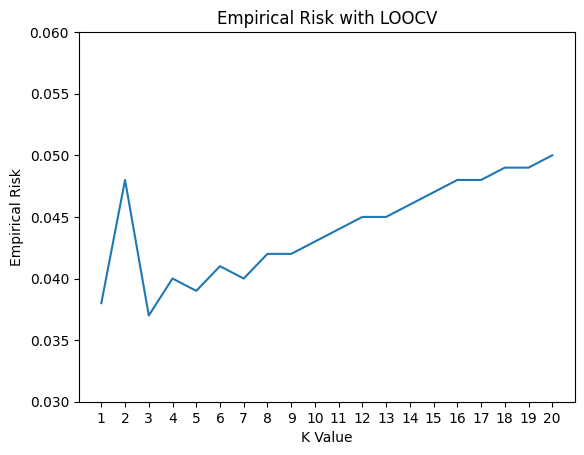

In [35]:
import matplotlib.pyplot as plt

plt.plot(k_list, KNN_big_df)
plt.xticks(k_list)
plt.ylim((0.03,0.06))
plt.xlabel('K Value')
plt.ylabel('Empirical Risk')
plt.title('Empirical Risk with LOOCV')
plt.show()

In [7]:
test_X_binary = (test_X > 128).astype(int)

In [8]:
KNN_test_big = KNN(k=3, distance=2)
KNN_test_big.fit(train_X_binary, train_y)

In [9]:
predictions_test = KNN_test_big.predict(test_X_binary)

In [10]:
error_test = KNN_test_big.error_score(predictions_test, test_y)

In [14]:
k_list = np.array([i for i in range(1,21)])
KNN_test_mult = KNN(k=k_list, distance=2)
KNN_test_mult.fit(train_X_binary, train_y)

In [15]:
test_error_mult = KNN_test_mult.error_mult(test_X_binary, test_y)

In [25]:
pd.DataFrame({'Empirical Risk on Test Set':test_error_mult}, index=k_list).round(decimals=3).to_csv(r'Plots/risk_test_big.csv')

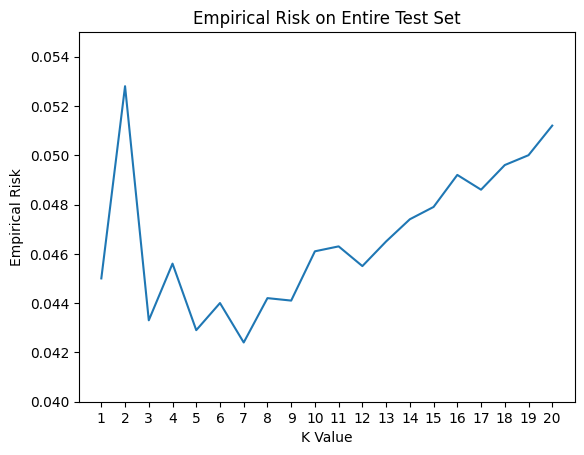

In [22]:
import matplotlib.pyplot as plt

plt.plot(k_list, test_error_mult)
plt.xticks(k_list)
plt.ylim((0.04,0.055))
plt.xlabel('K Value')
plt.ylabel('Empirical Risk')
plt.title('Empirical Risk on Entire Test Set')
plt.show()